In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

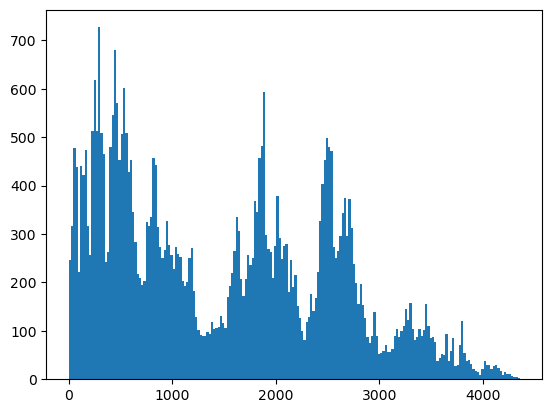

In [2]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('D:/data/Zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 200)

In [3]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [4]:
zircons_data = data[0]
ages = data[1][1:]
print(len(ages))

200


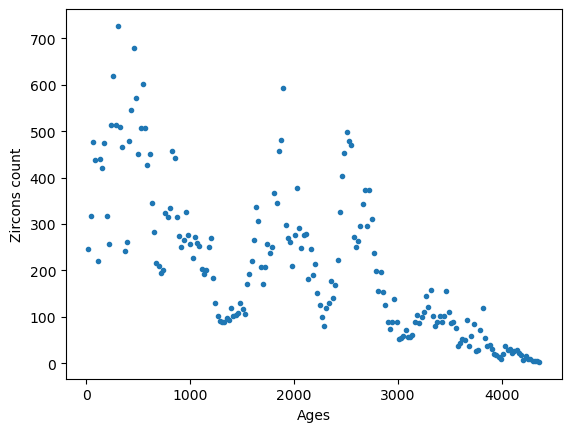

In [5]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [6]:
ages_nominal = np.arange(len(ages))

In [7]:
#k=4 , n=200
#读取用来查的表switchPointList

switchPointList4 = []

import csv

f = open('4_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList4.append(temp)
print(len(switchPointList4))

64684950


In [8]:
#k=3 , n=200
#读取用来查的表switchPointList

switchPointList3 = []

import csv

f = open('3_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList3.append(temp)
print(len(switchPointList3))

1313400


In [9]:
#k=2 , n=200
#读取用来查的表switchPointList

switchPointList2 = []

import csv

f = open('2_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList2.append(temp)
print(len(switchPointList2))

19900


In [10]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar], otypes=[at.lscalar])
def nCk_(k):
    return np.array(math.comb(200,k))

In [11]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar, at.dvector, at.lscalar], otypes=[at.dvector])
def rate_(index, rates, k):
    if k == 0:
        return rate0_(index, rates)
    if k == 1:
        return rate1_(index, rates)
    if k == 2:
        return rate2_(index, rates)
    if k == 3:
        return rate3_(index, rates)
    if k == 4:
        return rate4_(index, rates)

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate0_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    rate[:] = rates[0]
    return rate


@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate1_(index, rates):
    rate[:index] = rates[0]
    rate[index:] = rates[1]
    
    return rate


@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate2_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:] = rates[2]
    return rate

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate3_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:switchPoints[2]] = rates[2]
    rate[switchPoints[2]:] = rates[3]
    return rate


@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate4_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:switchPoints[2]] = rates[2]
    rate[switchPoints[2]:switchPoints[3]] = rates[3]
    rate[switchPoints[3]:] = rates[4]
    return rate

In [12]:
with pm.Model() as zircons_model:
    
    k = pm.DiscreteUniform("k", lower = 0, upper = 4)
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    

    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    rates = pm.Exponential("rates",1.0,shape = k+1)
    
    upper = nCk_(k)
    
    index = pm.DiscreteUniform("index", lower = 0, upper = upper)
    
    rate = rate_(index, rates , k)
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [13]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([k])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([rates])
    
    step3 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    #start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune = 10000, draws = 10000, step = [step1, step2, step3], cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

TypeError: expected type_num 9 (NPY_INT64) got 7
Apply node that caused the error: Elemwise{Composite}(FromFunctionOp{nCk_}.0, index, TensorConstant{0}, TensorConstant{-inf})
Toposort index: 4
Inputs types: [TensorType(int64, ()), TensorType(int64, ()), TensorType(int32, ()), TensorType(float32, ())]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(19900), array(9950, dtype=int64), array(0), array(-inf, dtype=float32)]
Outputs clients: [['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.